<a href="https://colab.research.google.com/github/Rathna-Reddy/Applied-GenAI-Lab/blob/main/notebooks/Add_docstring_generate_unit_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Generator for Unit Tests and Docstrings

This notebook provides a user interface for generating unit tests and docstrings for your code using different language models (GPT, Claude, and CodeQwen).

## Setup

1.  **Install necessary libraries:** Run the first code cell to install the `anthropic` library.
2.  **Get API keys:** Obtain API keys for the models you want to use (Hugging Face, OpenAI, Anthropic).
3.  **Add API keys to Colab Secrets:** Add your API keys to Colab's Secrets manager (under the "🔑" icon in the left panel) with the following names:
    *   `HF_TOKEN`
    *   `OPENAI_API_KEY`
    *   `ANTHROPIC_API_KEY`
4.  **Run the remaining setup cells:** Execute the code cells to import libraries, load API keys, and log in to Hugging Face.
5.  **Launch the Gradio UI:** Run the last code cell to launch the Gradio user interface.

## Usage

1.  Enter your code in the "Enter your code here" textbox.
2.  Select the desired language model from the "Choose your model" dropdown.
3.  Select the desired operation ("Unit Tests" or "Docstring/Comments") from the "Choose your operation" dropdown.
4.  Click the "Generate" button.

The generated unit tests or docstrings will appear in the "Output" textbox.

## Models

*   **GPT-o3-mini:** Uses the OpenAI `o3-mini-2025-01-31` model. This model can be run on a CPU.
*   **Claude-3.5-sonnet:** Uses the Anthropic `claude-3-5-sonnet-20240620` model. This model can be run on a CPU.
*   **CodeQwen:** Uses the Hugging Face `Qwen/Qwen2.5-7B-Instruct` model. This model requires a T4 GPU for execution.

## Code Structure

The notebook is structured with the following key components:

*   **API Key Loading:** Securely loads API keys from Colab secrets.
*   **Model Definitions:** Defines the model names used for generation.
*   **System Messages:** Defines the system messages used for the language models to guide their responses for unit test and docstring generation.
*   **User Prompts:** Defines functions to format user prompts for the language models.
*   **Streaming Functions:** Provides functions to stream responses from the different language models.
*   **Prompt Definition Function:** Determines the appropriate system and user messages based on the selected operation.
*   **Core Generation Function:** Calls the appropriate streaming function based on the selected model and operation.
*   **Gradio UI Creation:** Defines and launches the Gradio user interface for interacting with the code generator.

In [ ]:
!pip install anthropic

In [ ]:
import os
from google.colab import userdata
from openai import OpenAI
import anthropic

from huggingface_hub import login
from transformers import AutoTokenizer, TextStreamer, AutoModelForCausalLM

import gradio as gr
import torch

In [ ]:
# Google Colab User Data
# Ensure you have set the following in your Google Colab environment:
hf_token = userdata.get('HF_TOKEN')
openai_api_key = userdata.get('OPENAI_API_KEY')
anthropic_api_key = userdata.get('ANTHROPIC_API_KEY')

In [ ]:
login(hf_token, add_to_git_credential=True)
openai = OpenAI(api_key = openai_api_key)
anthropic = anthropic.Anthropic(api_key = anthropic_api_key)

In [ ]:
OPENAI = 'o3-mini-2025-01-31'
CLAUDE = 'claude-3-5-sonnet-20240620'

# Opensource model
QWEN = 'Qwen/Qwen2.5-7B-Instruct'

In [ ]:
TESTING = 'Unit Tests'
DOCSTRING = 'Docstring/Comments'

In [ ]:
system_message_unit_tests = """
You are an AI assistant specialized in creating unit tests. Your task is to generate high quality unit tests for code provided by the user.
Given the code, analyze the code and identify the main functionality, parameters, return values and possible edge cases.
Create comprehensive unit tests that cover the following aspects:
- normal use cases with expected inputs and outputs
- boundary cases and extreme values
- error handling and exceptions
- edge cases
Use the appropriate testing framework for the given code programming language (Example: pytest for python) and explain to the user why you choose this specific framework.
Structure the tests clearly with meaningful test names and add comments to explain the test logic.
Suplement your response with a brief explanation of the testing strategy and suggestions for improving the quality of the tests.
"""

system_message_docstring = """
You are an AI assistant specialized in creating docstrings. Your task is to generate high quality docstrings for code provided by the user.
Analyze the code to understand its main functionality and then produce a concise documentation that includes:
- a short summary of what the code does.
- a short description of the parameters, including their expected types.
- a short explanation of what the function returns.
- if it's a complex code, then only provide some key insights
- if applicable how the function can be used.
Ensure your documentation is written in standard concentions (e.g PEP 257 for python)
It should be understandable and easy to understand for other developers.
"""

In [ ]:
def user_prompt_docstring(code):
    user_prompt = f"""
    please add detailed docstring for the following code:
    {code}
    """
    return user_prompt

def user_prompt_unit_tests(code):
    user_prompt = f"""
      please generate unit tests for the following code using the appropriate framework:
      {code}
    """
    return user_prompt

In [ ]:
def stream_gpt(system_message, user_message):
    stream = openai.chat.completions.create(
        model=OPENAI,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message},
        ],
        stream=True,
    )

    response = ""
    for chunk in stream:
        delta = chunk.choices[0].delta.content or ""
        if delta:
            response += delta
            yield response


In [ ]:
def stream_claude(system_message, user_message):
    response = anthropic.messages.stream(
        model = CLAUDE,
        max_tokens = 2000,
        system = system_message,
        messages = [
            {"content": user_message, "role": "user"}
        ],
        temperature = 0.4
    )
    reply = ""
    with response as stream:
        for chunk in stream.text_stream:
            reply += chunk or ""
            yield reply

In [ ]:
def stream_qwen(system_message, user_message):
    tokenizer = AutoTokenizer.from_pretrained(QWEN, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        QWEN,
        device_map="auto",
        dtype="auto",
        trust_remote_code=True
    )

    inputs = tokenizer.apply_chat_template(
        [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message},
        ],
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    # autoregressive loop (manual streaming)
    generated = inputs
    reply = ""
    for _ in range(2000):  # max_new_tokens
        outputs = model.generate(
            generated,
            max_new_tokens=1,  # one token at a time
            do_sample=True
        )
        new_token_id = outputs[0, -1].unsqueeze(0).unsqueeze(0)  # shape [1,1]
        generated = torch.cat([generated, new_token_id.to(model.device)], dim=-1)

        # decode only the new token
        new_token_text = tokenizer.decode(new_token_id.squeeze(), skip_special_tokens=True)
        if new_token_text:
            reply += new_token_text
            yield reply



In [ ]:
def define_prompts(code, prompt_type):
    if prompt_type == TESTING:
        system_message = system_message_unit_tests
        user_prompt = user_prompt_unit_tests(code)
    elif prompt_type == DOCSTRING:
        system_message = system_message_docstring
        user_prompt = user_prompt_docstring(code)
    else:
        raise ValueError("Invalid prompt type")
    return system_message, user_prompt

In [ ]:
def create_test_comment(code, model, operation):
    system_message, user_prompt = define_prompts(code, operation)

    if model == 'GPT-o3-mini':
        gen = stream_gpt(system_message, user_prompt)
    elif model == 'Claude-3.5-sonnet':
        gen = stream_claude(system_message, user_prompt)
    elif model == 'CodeQwen':
        gen = stream_qwen(system_message, user_prompt)
    else:
        raise ValueError("Invalid model")

    yield from gen

In [ ]:
def create_ui():

    with gr.Blocks(title = 'Code Generator') as ui:
        gr.Markdown('# Code Generator for Unit Tests and Docstrings')

        with gr.Row():
            with gr.Column(min_width = 500):
                code = gr.Textbox(
                    label = 'Enter your code here',
                    lines = 20,
                    placeholder = 'Code...'
                )
                model = gr.Dropdown(['GPT-o3-mini', 'Claude-3.5-sonnet', 'CodeQwen'],
                                 label = 'Choose your model',
                                 value = 'GPT-o3-mini'
                                )
                operation = gr.Dropdown(
                    [TESTING, DOCSTRING],
                    label = 'Choose your operation',
                    value = TESTING
                )
                generate_button = gr.Button('Generate')

            with gr.Column():
                output = gr.Textbox(
                    label = 'Output',
                    lines = 20,
                    placeholder = 'Output...'
                )
        generate_button.click(fn = create_test_comment, inputs = [code, model, operation],
                              outputs = output)
    return ui

In [ ]:
ui = create_ui()
ui.launch()

#### Example docstring generated using GPT-o3-mini

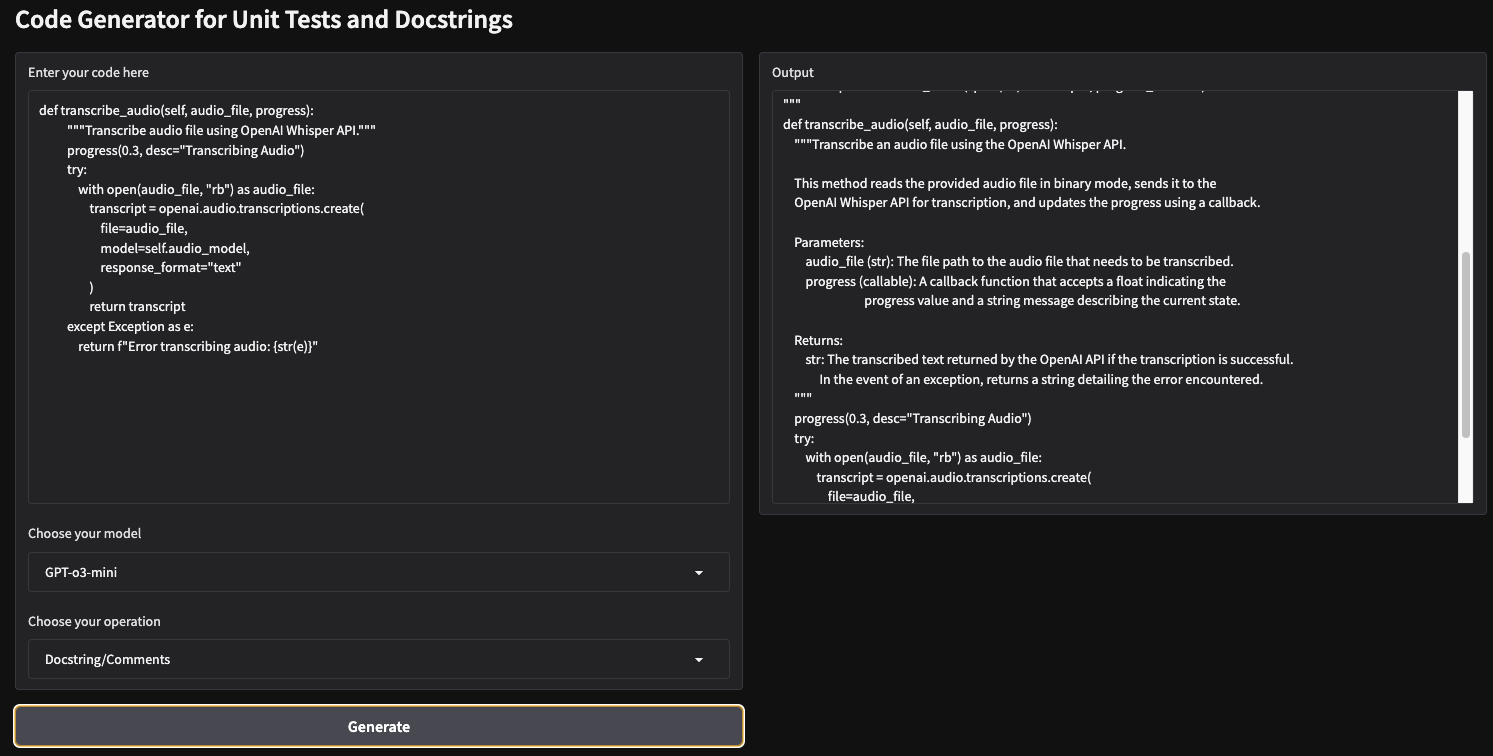

#### Example unit tests generated using GPT-o3-mini

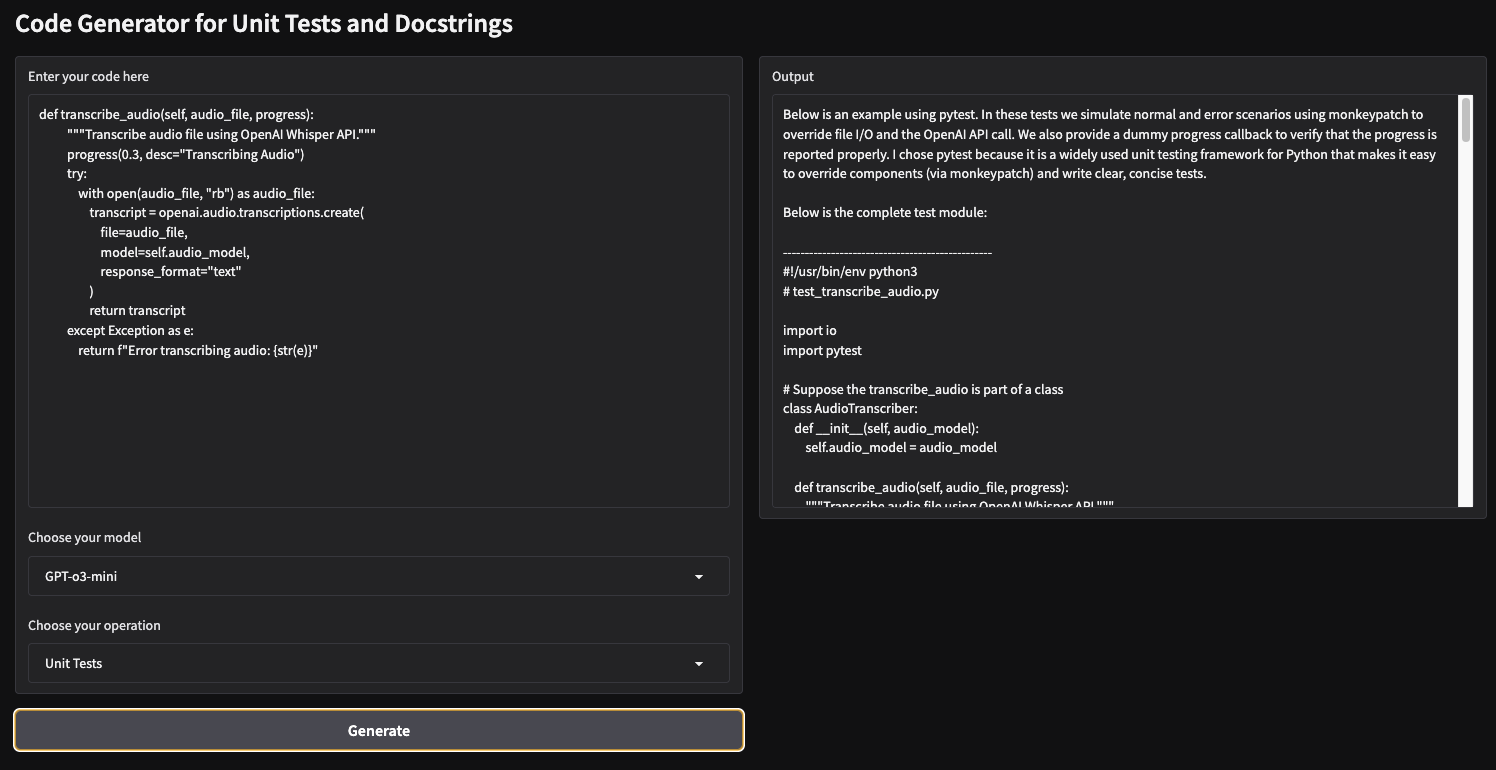

#### Example unit tests generated uisng Calude sonnet 3.5

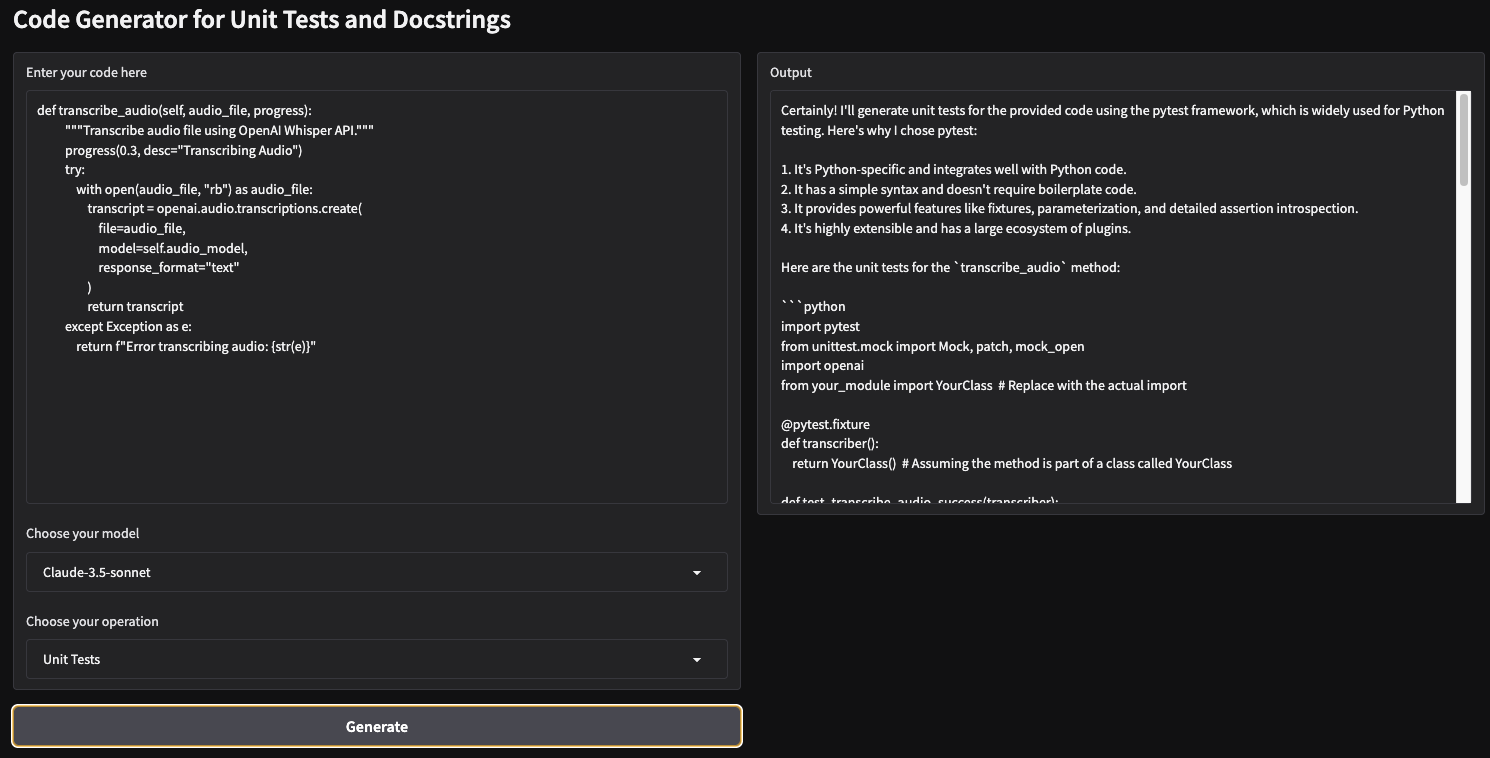

#### Example docstring generation using CodeQwen.

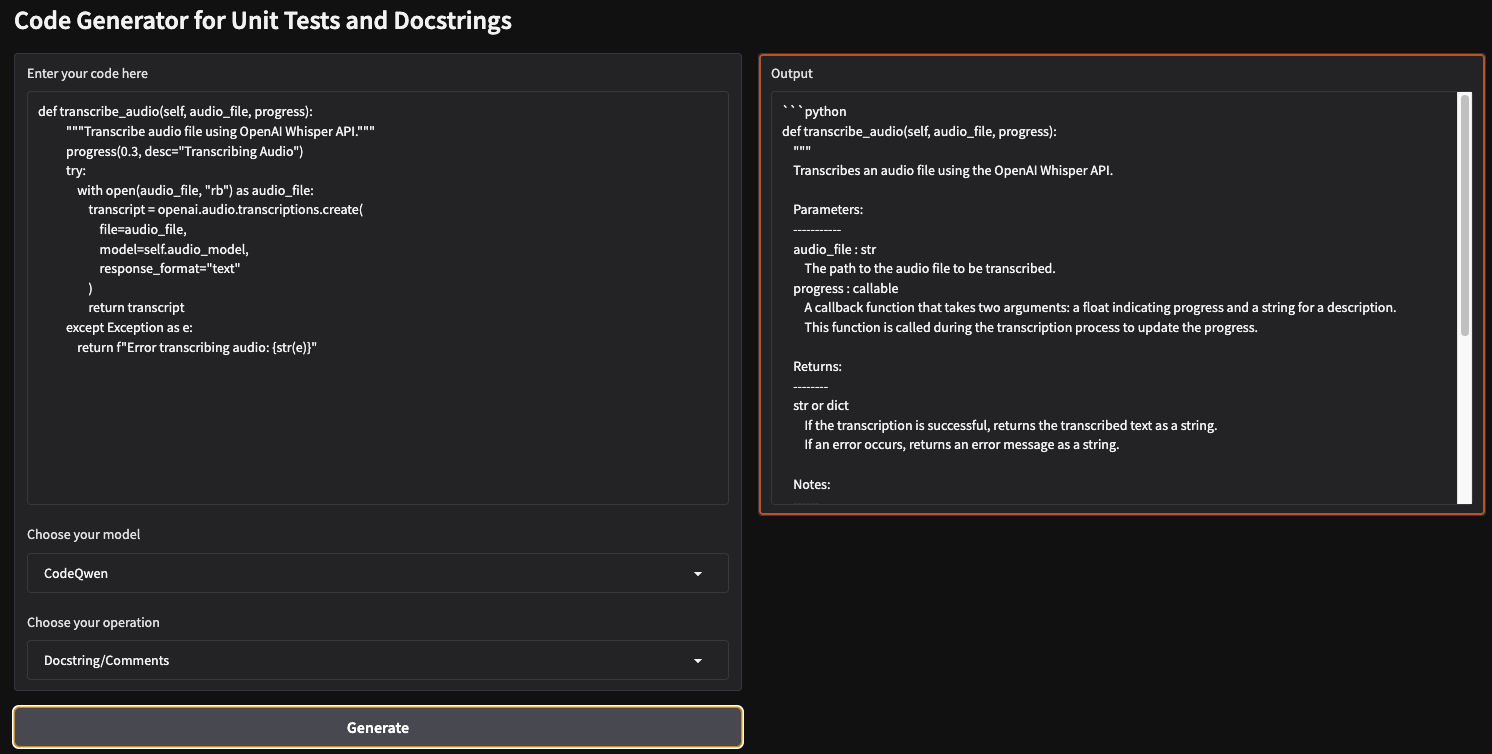

#### Example unit tests generation using CodeQwen.

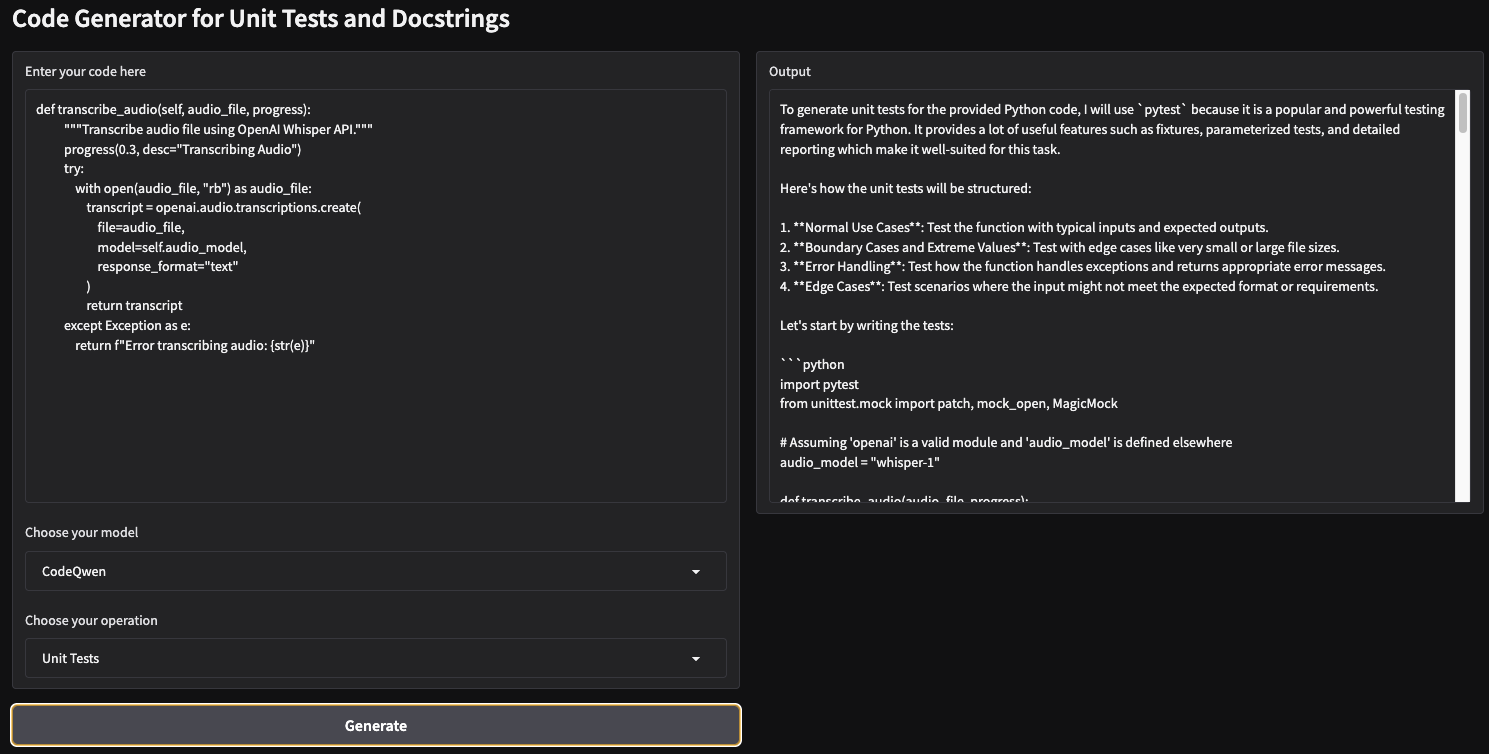